In [113]:
#pip install deepface

In [25]:
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns

import PIL 
from PIL import Image

import cv2
import time

from deepface import DeepFace

import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi
torch.cuda.is_available()

Wed Mar  5 04:01:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   59C    P0             13W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [4]:
# настроим random_seed всего
seed_num = 13
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
torch.use_deterministic_algorithms(True) # do not work in collab
np.random.seed(seed_num)

import torch.backends.cudnn
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # do not work in collab

In [5]:
# рабочие пути
project_path = r'F:\Codenrock\Kryptonite'
local_path = os.getcwd()
project_path

'F:\\Codenrock\\Kryptonite'

### Try model

ссылка на гитхаб фреймворка DeepFace https://github.com/serengil/deepface/tree/master

##### При запуске первый раз модель скачивает веса. Потом работает уже быстро

##### Первый режим работы

In [11]:
image_path = os.path.join(project_path, 'data', 'train', 'images', '000000')

result = DeepFace.verify(
  img1_path = os.path.join(image_path, "0.jpg"),
  img2_path = os.path.join(image_path, "1.jpg"),
)

In [17]:
%%time 

result = DeepFace.verify(
  img1_path = os.path.join(image_path, "0.jpg"),
  img2_path = os.path.join(image_path, "1.jpg"),
)

CPU times: total: 1.84 s
Wall time: 687 ms


In [17]:
result

{'verified': True,
 'distance': 0.38093279256577395,
 'threshold': 0.68,
 'model': 'VGG-Face',
 'detector_backend': 'opencv',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 15,
   'y': 14,
   'w': 202,
   'h': 202,
   'left_eye': None,
   'right_eye': None},
  'img2': {'x': 15,
   'y': 26,
   'w': 191,
   'h': 191,
   'left_eye': None,
   'right_eye': None}},
 'time': 2.58}

In [23]:
result['distance']

0.38093279256577395

In [40]:
# измерим время инференса

start_time = time.time()

result = DeepFace.verify(
  img1_path = os.path.join(image_path, "0.jpg"),
  img2_path = os.path.join(image_path, "1.jpg"),
)
# конечное время
end_time = time.time()
print('Inference time: ', end_time - start_time)

Inference time:  0.6655762195587158


In [17]:
# измерим время инференса, если перенесем фото с внешнего диска на С
local_image_path = r'C:\Users\serge\DS\Codenrock\Kryptonite\000000'
start_time = time.time()

result = DeepFace.verify(
  img1_path = os.path.join(local_image_path, "0.jpg"),
  img2_path = os.path.join(local_image_path, "1.jpg"),
)
# конечное время
end_time = time.time()
print('Inference time: ', end_time - start_time)

Inference time:  0.6288270950317383


Время инференса меняется от запуска к запуску на одной и той же паре фото. Составляет от 0.6 до 1.2. Перенос с внешнего диска особо скорости не добавил

##### Второй режим работы

In [108]:
embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)

for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])
embedding_0 

array([0., 0., 0., ..., 0., 0., 0.])

In [110]:
  img_path = os.path.join(local_image_path, "1.jpg")
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])
embedding_1

array([0., 0., 0., ..., 0., 0., 0.])

In [114]:
sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))
sim_scores

array([[0.61906721]])

In [116]:
1-0.38093279256577395

0.619067207434226

##### Результат обоими способами совпадает:)

In [178]:
# check time
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "1.jpg") # real
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

# конечное время
end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.6533646583557129
[[0.61906721]]


Время тоже меняется, нужны массовые замеры, чтобы посчитать среднее

### Посмотрим сравнение real face и deepfake глазами

In [180]:
# check time CPU
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "2.jpg") # fake
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.6491076946258545
[[0.6079998]]


In [182]:
# check time CPU
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "3.jpg") # fake
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.646836519241333
[[0.43059926]]


In [184]:
# check time CPU
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "4.jpg") # real
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.7515063285827637
[[0.55766013]]


In [186]:
# check time CPU
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "5.jpg") # real
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.6569499969482422
[[0.62218966]]


In [188]:
# check time CPU
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "6.jpg") # fake
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.661942720413208
[[0.44014376]]


In [190]:
# check time CPU
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "7.jpg") # fake
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.6849393844604492
[[0.5188896]]


In [192]:
# check time CPU
start_time = time.time()

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "0.jpg")
)
for embedding_obj in embedding_objs:
  embedding_0 = np.array(embedding_obj["embedding"])

embedding_objs = DeepFace.represent(
  img_path = os.path.join(local_image_path, "8.jpg") # fake
)

for embedding_obj in embedding_objs:
  embedding_1 = np.array(embedding_obj["embedding"])

sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))

end_time = time.time()
print('Inference time: ', end_time - start_time)
print(sim_scores)

Inference time:  0.6550729274749756
[[0.53975732]]


In [194]:
len(embedding_1)

4096

Real vs Fake в этой папке оценивается ниже, чем Real vs Real. Чтобы полноценно это доказать, нужно сравнение по трейновому датасету.
Но скорость инференса крайне низкая. Побробуем подобрать бэкбоун побыстрее.

### Backbone Comparison

In [19]:
imgs_comparison_list = os.listdir(local_image_path)
len(imgs_comparison_list)

9

In [21]:
def compare_imgs(model, path):
    res = []
    embedding_objs = DeepFace.represent(img_path = os.path.join(path, "0.jpg"), enforce_detection = False, model_name = model)
    for embedding_obj in embedding_objs:
      embedding_0 = np.array(embedding_obj["embedding"])    
    for img in range(1, len(imgs_comparison_list)):
        start_time = time.time()   
        name = str(img) + '.jpg'
        embedding_objs = DeepFace.represent(img_path = os.path.join(path, name), enforce_detection = False, model_name = model)
        for embedding_obj in embedding_objs:
          embedding_1 = np.array(embedding_obj["embedding"])
        sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))
        end_time = time.time()
        res.append([name, sim_scores[0][0], end_time - start_time])
    return pd.DataFrame(res, columns = ['img_2', 'cos_sim', 'time'])

In [37]:
vgg_res = compare_imgs("VGG-Face", local_image_path)
vgg_res

,img_2,cos_sim,time
0,1.jpg,0.619067,0.283330
1,2.jpg,0.608000,0.321746
2,3.jpg,0.430599,0.302622
3,4.jpg,0.557660,0.325660
4,5.jpg,0.622190,0.288249
5,6.jpg,0.440144,0.344581
6,7.jpg,0.518890,0.283063
7,8.jpg,0.539757,0.300061


In [38]:
face_net_res = compare_imgs("Facenet", local_image_path)
face_net_res

,img_2,cos_sim,time
0,1.jpg,0.795937,0.233232
1,2.jpg,0.666713,0.249881
2,3.jpg,0.698489,0.250910
3,4.jpg,0.807505,0.247659
4,5.jpg,0.842795,0.250927
5,6.jpg,0.704719,0.233027
6,7.jpg,0.742352,0.249872
7,8.jpg,0.762128,0.272656


In [39]:
face_net_512_res = compare_imgs("Facenet512", local_image_path)
face_net_512_res

,img_2,cos_sim,time
0,1.jpg,0.810955,0.249847
1,2.jpg,0.695080,0.255564
2,3.jpg,0.679240,0.236072
3,4.jpg,0.809689,0.241143
4,5.jpg,0.870042,0.249858
5,6.jpg,0.825052,0.241378
6,7.jpg,0.809848,0.244299
7,8.jpg,0.825844,0.265758


In [41]:
open_face_res = compare_imgs("OpenFace", local_image_path)
open_face_res

,img_2,cos_sim,time
0,1.jpg,0.621508,0.123224
1,2.jpg,0.625966,0.108740
2,3.jpg,0.596473,0.099964
3,4.jpg,0.786489,0.116575
4,5.jpg,0.631177,0.119626
5,6.jpg,0.352457,0.113519
6,7.jpg,0.674120,0.116653
7,8.jpg,0.678561,0.133218


In [42]:
deep_id_res = compare_imgs("DeepID", local_image_path)
deep_id_res

,img_2,cos_sim,time
0,1.jpg,0.977524,0.038991
1,2.jpg,0.919044,0.042475
2,3.jpg,0.919890,0.029066
3,4.jpg,0.973824,0.042246
4,5.jpg,0.980442,0.043900
5,6.jpg,0.790755,0.040056
6,7.jpg,0.889377,0.039062
7,8.jpg,0.975122,0.057970


In [45]:
arc_face_res = compare_imgs("ArcFace", local_image_path)
arc_face_res

,img_2,cos_sim,time
0,1.jpg,0.736856,0.196290
1,2.jpg,0.583269,0.197044
2,3.jpg,0.531124,0.203160
3,4.jpg,0.803240,0.196977
4,5.jpg,0.731705,0.196247
5,6.jpg,0.651886,0.199785
6,7.jpg,0.633849,0.200263
7,8.jpg,0.673043,0.222380


In [31]:
SFace_res = compare_imgs("SFace", local_image_path)
SFace_res

25-03-05 04:05:23 - face_recognition_sface_2021dec.onnx weights will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_zoo/raw/main/models/face_recognition_sface/face_recognition_sface_2021dec.onnx
To: C:\Users\serge\.deepface\weights\face_recognition_sface_2021dec.onnx
100%|██████████| 38.7M/38.7M [00:03<00:00, 9.76MB/s]


,img_2,cos_sim,time
0,1.jpg,0.500815,0.049927
1,2.jpg,0.577125,0.049970
2,3.jpg,0.449707,0.049855
3,4.jpg,0.710185,0.040926
4,5.jpg,0.633875,0.054073
5,6.jpg,0.497414,0.045856
6,7.jpg,0.571472,0.042444
7,8.jpg,0.498756,0.066701


In [33]:
ghost_res = compare_imgs("GhostFaceNet", local_image_path)
ghost_res

25-03-05 04:05:52 - Pre-trained weights is downloaded from https://github.com/HamadYA/GhostFaceNets/releases/download/v1.2/GhostFaceNet_W1.3_S1_ArcFace.h5 to C:\Users\serge\.deepface/weights/ghostfacenet_v1.h5


Downloading...
From: https://github.com/HamadYA/GhostFaceNets/releases/download/v1.2/GhostFaceNet_W1.3_S1_ArcFace.h5
To: C:\Users\serge\.deepface\weights\ghostfacenet_v1.h5
100%|██████████| 17.3M/17.3M [00:02<00:00, 7.68MB/s]


25-03-05 04:05:55 - Pre-trained weights is just downloaded to C:\Users\serge\.deepface/weights/ghostfacenet_v1.h5


,img_2,cos_sim,time
0,1.jpg,0.330522,0.200233
1,2.jpg,0.552727,0.216774
2,3.jpg,0.565779,0.215912
3,4.jpg,0.550898,0.234051
4,5.jpg,0.616968,0.248986
5,6.jpg,0.492213,0.216546
6,7.jpg,0.486151,0.199950
7,8.jpg,0.527255,0.216736


In [59]:
total_res = pd.DataFrame(columns = ['img', 'status', 'vgg_res', 'face_net_res', 'face_net_512_res', 'open_face_res', 'deep_id_res', 
                                    'arc_face_res', 'SFace_res', 'ghost_res'])
total_res['img'] = vgg_res['img_2']
total_res['status'] = [0, 1, 1, 0, 0, 1, 1, 1]
total_res['vgg_res'] = vgg_res['cos_sim']
total_res['face_net_res'] = face_net_res['cos_sim']
total_res['face_net_512_res'] = face_net_512_res['cos_sim']
total_res['open_face_res'] = open_face_res['cos_sim']
total_res['deep_id_res'] = deep_id_res['cos_sim']
total_res['arc_face_res'] = arc_face_res['cos_sim']
total_res['SFace_res'] = SFace_res['cos_sim']
total_res['ghost_res'] = ghost_res['cos_sim']

total_res

,img,status,vgg_res,face_net_res,face_net_512_res,open_face_res,deep_id_res,arc_face_res,SFace_res,ghost_res
0,1.jpg,0,0.619067,0.795937,0.810955,0.621508,0.977524,0.736856,0.500815,0.330522
1,2.jpg,1,0.608000,0.666713,0.695080,0.625966,0.919044,0.583269,0.577125,0.552727
2,3.jpg,1,0.430599,0.698489,0.679240,0.596473,0.919890,0.531124,0.449707,0.565779
3,4.jpg,0,0.557660,0.807505,0.809689,0.786489,0.973824,0.803240,0.710185,0.550898
4,5.jpg,0,0.622190,0.842795,0.870042,0.631177,0.980442,0.731705,0.633875,0.616968
5,6.jpg,1,0.440144,0.704719,0.825052,0.352457,0.790755,0.651886,0.497414,0.492213
6,7.jpg,1,0.518890,0.742352,0.809848,0.674120,0.889377,0.633849,0.571472,0.486151
7,8.jpg,1,0.539757,0.762128,0.825844,0.678561,0.975122,0.673043,0.498756,0.527255


In [61]:
total_res_time = pd.DataFrame(columns = ['img', 'vgg_res', 'face_net_res', 'face_net_512_res', 'open_face_res', 'deep_id_res', 
                                    'arc_face_res', 'SFace_res', 'ghost_res'])
total_res_time['img'] = vgg_res['img_2']
total_res_time['vgg_res'] = vgg_res['time']
total_res_time['face_net_res'] = face_net_res['time']
total_res_time['face_net_512_res'] = face_net_512_res['time']
total_res_time['open_face_res'] = open_face_res['time']
total_res_time['deep_id_res'] = deep_id_res['time']
total_res_time['arc_face_res'] = arc_face_res['time']
total_res_time['SFace_res'] = SFace_res['time']
total_res_time['ghost_res'] = ghost_res['time']

total_res_time

,img,vgg_res,face_net_res,face_net_512_res,open_face_res,deep_id_res,arc_face_res,SFace_res,ghost_res
0,1.jpg,0.283330,0.233232,0.249847,0.123224,0.038991,0.196290,0.049927,0.200233
1,2.jpg,0.321746,0.249881,0.255564,0.108740,0.042475,0.197044,0.049970,0.216774
2,3.jpg,0.302622,0.250910,0.236072,0.099964,0.029066,0.203160,0.049855,0.215912
3,4.jpg,0.325660,0.247659,0.241143,0.116575,0.042246,0.196977,0.040926,0.234051
4,5.jpg,0.288249,0.250927,0.249858,0.119626,0.043900,0.196247,0.054073,0.248986
5,6.jpg,0.344581,0.233027,0.241378,0.113519,0.040056,0.199785,0.045856,0.216546
6,7.jpg,0.283063,0.249872,0.244299,0.116653,0.039062,0.200263,0.042444,0.199950
7,8.jpg,0.300061,0.272656,0.265758,0.133218,0.057970,0.222380,0.066701,0.216736


##### В целом, все модели оценивали Real vs Fake ниже, чем Real vs Real. Возможно, можно это использовать - в модели есть параметр threshold.
Наивысшие cos_sim показал deep_id_res, он же был самым быстрым. Попробуем сделать выгрузку на нем. 

### Inference on pretrained DeepFace: deep_id_res

In [123]:
ssd_path = r'F:\Codenrock\Kryptonite\data\test_public\images'
ssd_list_dir = os.listdir(ssd_path)
ssd_list_dir[0]

'00000000'

In [79]:
cos_sims = []
start_time = time.time()
beg_time = start_time
for folder in ssd_list_dir:    
    image_path = os.path.join(ssd_path, folder)
    embedding_objs = DeepFace.represent(img_path = os.path.join(image_path, "0.jpg"), enforce_detection = False, model_name = 'DeepID')
    for embedding_obj in embedding_objs:
      embedding_0 = np.array(embedding_obj["embedding"])    
    embedding_objs = DeepFace.represent(img_path = os.path.join(image_path, "1.jpg"), enforce_detection = False, model_name = 'DeepID')    
    for embedding_obj in embedding_objs:
      embedding_1 = np.array(embedding_obj["embedding"])    
    sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))
    cos_sims.append([folder, sim_scores])
    if int(folder) % 1000 == 0:
        print(f'Current time: {folder} ', time.time() - beg_time)  
        beg_time = time.time()

end_time = time.time()
print('Inference time: ', end_time - start_time)

Current time: 00000000  0.1233069896697998
Current time: 00001000  99.38783764839172
Current time: 00002000  99.2624900341034
Current time: 00003000  100.33959436416626
Current time: 00004000  99.13906502723694
Current time: 00005000  103.79435133934021
Current time: 00006000  103.86499977111816
Current time: 00007000  102.40512251853943
Current time: 00008000  100.63918590545654
Current time: 00009000  102.40499877929688
Current time: 00010000  103.05476927757263
Current time: 00011000  102.80469465255737
Current time: 00012000  107.45202708244324
Current time: 00013000  103.55402636528015
Current time: 00014000  105.6198673248291
Current time: 00015000  105.00326585769653
Current time: 00016000  103.93748831748962
Current time: 00017000  105.56974530220032
Current time: 00018000  102.5714328289032
Current time: 00019000  106.6368842124939
Current time: 00020000  101.1949052810669
Current time: 00021000  107.94578671455383
Current time: 00022000  105.37068367004395
Current time: 00023

In [83]:
len(cos_sims)

161191

In [87]:
preds = pd.DataFrame(cos_sims, columns = ['pair_id', 'similarity'])
preds

,pair_id,similarity
0,00000000,[[1.0]]
1,00000001,[[0.8499120443980509]]
2,00000002,[[0.7018126678136867]]
3,00000003,[[0.8081231677031278]]
4,00000004,[[0.869009833958676]]
...,...,...
161186,00161186,[[0.9814701313950365]]
161187,00161187,[[0.9503068789174927]]
161188,00161188,[[0.9558576937296217]]
161189,00161189,[[0.8838035792604774]]


In [101]:
sim_np = preds['similarity']
sim_single = []
for sim in sim_np:
    sim_single.append(sim[0][0])

In [105]:
preds['similarity'] = sim_single
preds

,pair_id,similarity
0,00000000,1.000000
1,00000001,0.849912
2,00000002,0.701813
3,00000003,0.808123
4,00000004,0.869010
...,...,...
161186,00161186,0.981470
161187,00161187,0.950307
161188,00161188,0.955858
161189,00161189,0.883804


In [109]:
preds.to_csv('submission_v0.csv', index = False)

In [111]:
preds.loc[preds['similarity']<0.5]

,pair_id,similarity
21589,00021589,0.491716
58591,00058591,0.417575
58607,00058607,0.430657
91027,00091027,0.362581
91050,00091050,0.439927
102837,00102837,0.426483
102860,00102860,0.488667
135237,00135237,0.477057
146018,00146018,0.470802
147637,00147637,0.411685


##### Фотографий разных людей, по мнению модели, было 13:)

### Проверим точность на трейновой выборке

In [153]:
train_path = r'F:\Codenrock\Kryptonite\data\train\images'
train_list = os.listdir(train_path)
print(train_path)
print(train_list[0])

F:\Codenrock\Kryptonite\data\train\images
000000


In [169]:
def embeddings_imgs(model, path, folder):    
    res = [] 
    for img in os.listdir(os.path.join(train_path, folder)):         
        name = img
        embedding_objs = DeepFace.represent(img_path = os.path.join(path, folder, name), enforce_detection = False, model_name = model)
        for embedding_obj in embedding_objs:
          embedding = np.array(embedding_obj["embedding"])        
        res.append([folder, name, embedding])
    return res

In [171]:
deepid_res = [] 
start_time = time.time() 
for i in range(100):
    folder = str(train_list[i])
    folder_res = embeddings_imgs('DeepID', train_path, folder)
    deepid_res.extend(folder_res)

end_time = time.time()
print(end_time - start_time)

44.65613555908203


In [222]:
deepid_res[0]

['000000',
 '0.jpg',
 array([ 0.        ,  0.        , 27.68024063, 42.7077713 ,  0.        ,
         0.        , 38.52863693,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 18.73038483,  0.        ,  0.        ,
         0.        ,  0.        , 11.90367889, 17.29180908,  0.        ,
         0.        ,  0.        ,  0.        , 37.98587799,  0.        ,
        19.78820038,  0.        ,  0.        ,  0.        ,  0.        ,
         6.30541229, 40.7433815 , 13.12581062, 10.58197784, 28.06858826,
         0.        , 27.41318893,  0.        ,  7.04427052, 49.38085938,
         0.        , 16.33803368, 14.85646629,  0.        ,  5.43019581,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.91015029,  0.        ,  0.        , 31.67269516,  0.        ,
         0.        ,  8.43167496,  0.        ,  0.        , 28.6852417 ,
        42.58583069,  2.20049667,  0.        , 30.6361866 ,  0.        ,
         0.        , 21.658042

In [193]:
deepid_sface_comparison_table = pd.DataFrame(deepid_res, columns = ['folder', 'img', 'deepid_emb'])
deepid_sface_comparison_table

,folder,img,deepid_emb
0,000000,0.jpg,"[0.0, 0.0, 27.680240631103516, 42.707771301269..."
1,000000,1.jpg,"[0.0, 0.0, 33.54344940185547, 36.9916191101074..."
2,000000,2.jpg,"[0.0, 0.0, 15.570091247558594, 55.597503662109..."
3,000000,3.jpg,"[0.0, 0.0, 25.535768508911133, 67.745262145996..."
4,000000,4.jpg,"[0.0, 0.0, 23.234220504760742, 33.589721679687..."
...,...,...,...
977,000099,5.jpg,"[0.0, 0.0, 28.389305114746094, 35.775382995605..."
978,000099,6.jpg,"[0.0, 0.0, 26.138803482055664, 42.236392974853..."
979,000099,7.jpg,"[0.0, 0.0, 21.200151443481445, 50.710739135742..."
980,000099,8.jpg,"[0.0, 0.0, 17.62405014038086, 53.2957687377929..."


In [179]:
sface_res = [] 
start_time = time.time() 
for i in range(100):
    folder = str(train_list[i])
    folder_res = embeddings_imgs('SFace', train_path, folder)
    sface_res.extend(folder_res)

end_time = time.time()
print(end_time - start_time)

49.756044149398804


In [206]:
sface_res[0]

['000000',
 '0.jpg',
 array([-8.92917156e-01, -7.10150972e-03,  4.21016574e-01,  3.84524763e-01,
         3.18964154e-01,  4.35859710e-02,  6.11789048e-01,  1.82081246e+00,
         5.50046325e-01,  6.27128839e-01, -7.19825387e-01,  4.52818036e-01,
        -1.41791916e+00, -9.19926941e-01,  1.10160355e-02, -1.91215277e-01,
        -1.83013618e-01,  1.06354797e+00, -1.21986151e+00,  1.08593416e+00,
        -2.99313396e-01,  1.45472586e+00, -7.75469720e-01, -1.33304074e-01,
        -1.82286799e-01,  1.99686527e-01, -4.55535620e-01, -1.80475354e-01,
        -6.91222727e-01,  1.40756965e+00, -3.22650820e-01,  6.98331475e-01,
         4.61479872e-02,  7.76698351e-01, -1.51922476e+00,  8.66250217e-01,
        -9.49884415e-01,  1.43731058e+00, -5.54114580e-01,  2.78151631e-01,
        -4.27812040e-02, -1.61760497e+00, -1.12419650e-01,  1.09912232e-01,
        -1.76778781e+00, -1.85205770e+00, -2.04104662e+00,  1.65794134e-01,
        -7.75255442e-01,  1.63408375e+00, -7.84512281e-01, -5.50254

In [197]:
sface_comparison_table = pd.DataFrame(sface_res, columns = ['folder', 'img', 'sface_emb'])
sface_comparison_table

,folder,img,sface_emb
0,000000,0.jpg,"[-0.8929171562194824, -0.007101509720087051, 0..."
1,000000,1.jpg,"[-0.5644903182983398, -1.0675445795059204, -0...."
2,000000,2.jpg,"[-1.7392849922180176, -0.694801926612854, -0.0..."
3,000000,3.jpg,"[-1.4213613271713257, -0.3801100254058838, 0.4..."
4,000000,4.jpg,"[-1.9582245349884033, -1.001584768295288, -0.5..."
...,...,...,...
977,000099,5.jpg,"[-0.5222467184066772, -0.4775097072124481, -0...."
978,000099,6.jpg,"[0.01616629958152771, 0.010355846025049686, 0...."
979,000099,7.jpg,"[-0.10601244866847992, -0.1252673715353012, 0...."
980,000099,8.jpg,"[-0.82204270362854, -0.5719301104545593, 0.674..."


In [201]:
deepid_sface_comparison_table = deepid_sface_comparison_table.merge(sface_comparison_table, how = 'inner', on = ['folder', 'img'])
deepid_sface_comparison_table

,folder,img,deepid_emb,sface_emb
0,000000,0.jpg,"[0.0, 0.0, 27.680240631103516, 42.707771301269...","[-0.8929171562194824, -0.007101509720087051, 0..."
1,000000,1.jpg,"[0.0, 0.0, 33.54344940185547, 36.9916191101074...","[-0.5644903182983398, -1.0675445795059204, -0...."
2,000000,2.jpg,"[0.0, 0.0, 15.570091247558594, 55.597503662109...","[-1.7392849922180176, -0.694801926612854, -0.0..."
3,000000,3.jpg,"[0.0, 0.0, 25.535768508911133, 67.745262145996...","[-1.4213613271713257, -0.3801100254058838, 0.4..."
4,000000,4.jpg,"[0.0, 0.0, 23.234220504760742, 33.589721679687...","[-1.9582245349884033, -1.001584768295288, -0.5..."
...,...,...,...,...
977,000099,5.jpg,"[0.0, 0.0, 28.389305114746094, 35.775382995605...","[-0.5222467184066772, -0.4775097072124481, -0...."
978,000099,6.jpg,"[0.0, 0.0, 26.138803482055664, 42.236392974853...","[0.01616629958152771, 0.010355846025049686, 0...."
979,000099,7.jpg,"[0.0, 0.0, 21.200151443481445, 50.710739135742...","[-0.10601244866847992, -0.1252673715353012, 0...."
980,000099,8.jpg,"[0.0, 0.0, 17.62405014038086, 53.2957687377929...","[-0.82204270362854, -0.5719301104545593, 0.674..."


In [315]:
opface_res = [] 
start_time = time.time() 
for i in range(100):
    folder = str(train_list[i])
    folder_res = embeddings_imgs('OpenFace', train_path, folder)
    opface_res.extend(folder_res)

end_time = time.time()
print(end_time - start_time)

124.6859622001648


In [316]:
opface_comparison_table = pd.DataFrame(opface_res, columns = ['folder', 'img', 'opface_emb'])
opface_comparison_table

,folder,img,opface_emb
0,000000,0.jpg,"[0.08460597693920135, 0.14440858364105225, -0...."
1,000000,1.jpg,"[0.0703054815530777, 0.035664815455675125, -0...."
2,000000,2.jpg,"[0.06271801143884659, 0.04871482774615288, -0...."
3,000000,3.jpg,"[0.00010086474503623322, 0.1256926953792572, -..."
4,000000,4.jpg,"[-0.020778458565473557, 0.10858029127120972, -..."
...,...,...,...
977,000099,5.jpg,"[-0.13752855360507965, 0.024747788906097412, 0..."
978,000099,6.jpg,"[-0.013997288420796394, 0.02581242099404335, 0..."
979,000099,7.jpg,"[-0.0035315777640789747, 0.017999086529016495,..."
980,000099,8.jpg,"[-0.06820577383041382, 0.058780279010534286, 0..."


In [317]:
deepid_sface_comparison_table = deepid_sface_comparison_table.merge(opface_comparison_table, how = 'inner', on = ['folder', 'img'])
deepid_sface_comparison_table

,folder,img,deepid_emb,sface_emb,opface_emb
0,000000,0.jpg,"[0.0, 0.0, 27.680240631103516, 42.707771301269...","[-0.8929171562194824, -0.007101509720087051, 0...","[0.08460597693920135, 0.14440858364105225, -0...."
1,000000,1.jpg,"[0.0, 0.0, 33.54344940185547, 36.9916191101074...","[-0.5644903182983398, -1.0675445795059204, -0....","[0.0703054815530777, 0.035664815455675125, -0...."
2,000000,2.jpg,"[0.0, 0.0, 15.570091247558594, 55.597503662109...","[-1.7392849922180176, -0.694801926612854, -0.0...","[0.06271801143884659, 0.04871482774615288, -0...."
3,000000,3.jpg,"[0.0, 0.0, 25.535768508911133, 67.745262145996...","[-1.4213613271713257, -0.3801100254058838, 0.4...","[0.00010086474503623322, 0.1256926953792572, -..."
4,000000,4.jpg,"[0.0, 0.0, 23.234220504760742, 33.589721679687...","[-1.9582245349884033, -1.001584768295288, -0.5...","[-0.020778458565473557, 0.10858029127120972, -..."
...,...,...,...,...,...
977,000099,5.jpg,"[0.0, 0.0, 28.389305114746094, 35.775382995605...","[-0.5222467184066772, -0.4775097072124481, -0....","[-0.13752855360507965, 0.024747788906097412, 0..."
978,000099,6.jpg,"[0.0, 0.0, 26.138803482055664, 42.236392974853...","[0.01616629958152771, 0.010355846025049686, 0....","[-0.013997288420796394, 0.02581242099404335, 0..."
979,000099,7.jpg,"[0.0, 0.0, 21.200151443481445, 50.710739135742...","[-0.10601244866847992, -0.1252673715353012, 0....","[-0.0035315777640789747, 0.017999086529016495,..."
980,000099,8.jpg,"[0.0, 0.0, 17.62405014038086, 53.2957687377929...","[-0.82204270362854, -0.5719301104545593, 0.674...","[-0.06820577383041382, 0.058780279010534286, 0..."


In [246]:
# open real/fake labels
with open(os.path.join(project_path, 'data', 'train', 'meta.json'), 'r') as myfile:
    data = myfile.read()

# parse file
meta = json.loads(data)

In [325]:
deepid_sface_comparison_table_np = np.array(deepid_sface_comparison_table)
len(deepid_sface_comparison_table_np)

982

In [327]:
emb_cos_sims = []

for i in range(len(deepid_sface_comparison_table_np)):
    img_1 = deepid_sface_comparison_table_np[i]
    img_1_label = meta[img_1[0] + '/' + img_1[1]]
    for j in range(len(deepid_sface_comparison_table_np)):
        img_2 = deepid_sface_comparison_table_np[j]
        img_2_label = meta[img_2[0] + '/' + img_2[1]]
        deep_id_cos_sim = cosine_similarity(img_1[2].reshape(1, -1), img_2[2].reshape(1, -1))
        sface_cos_sim = cosine_similarity(img_1[3].reshape(1, -1), img_2[3].reshape(1, -1))
        opface_cos_sim = cosine_similarity(img_1[4].reshape(1, -1), img_2[4].reshape(1, -1))
        if img_1[0] == img_2[0]:
            id_label = 'same'
        else:
            id_label = 'other'
        emb_cos_sims.append([img_1[0], img_1[1], img_1_label, img_2[0], img_2[1], img_2_label, id_label, deep_id_cos_sim[0][0], sface_cos_sim[0][0], opface_cos_sim[0][0]])

In [328]:
cos_sim_comparison = pd.DataFrame(emb_cos_sims, columns = ['folder_1', 'img_1', 'label_1', 'folder_2', 'img_2', 'label_2', 'id', 'deepid_cos_sim', 'sface_cos_sim', 'opface_cos_sim'])
cos_sim_comparison

,folder_1,img_1,label_1,folder_2,img_2,label_2,id,deepid_cos_sim,sface_cos_sim,opface_cos_sim
0,000000,0.jpg,0,000000,0.jpg,0,same,1.000000,1.000000,1.000000
1,000000,0.jpg,0,000000,1.jpg,0,same,0.977524,0.500815,0.621508
2,000000,0.jpg,0,000000,2.jpg,1,same,0.919044,0.577125,0.625966
3,000000,0.jpg,0,000000,3.jpg,1,same,0.919890,0.449707,0.596473
4,000000,0.jpg,0,000000,4.jpg,0,same,0.973824,0.710185,0.786489
...,...,...,...,...,...,...,...,...,...,...
964319,000099,9.jpg,1,000099,5.jpg,1,same,0.946446,0.663952,0.710344
964320,000099,9.jpg,1,000099,6.jpg,1,same,0.968940,0.692125,0.741170
964321,000099,9.jpg,1,000099,7.jpg,0,same,0.888479,0.220265,0.278157
964322,000099,9.jpg,1,000099,8.jpg,1,same,0.958719,0.851287,0.872703


In [329]:
same_df = cos_sim_comparison.loc[(cos_sim_comparison['label_1'] == 0) & (cos_sim_comparison['label_2'] == 0) & (cos_sim_comparison['id'] == 'same')]
same_df

,folder_1,img_1,label_1,folder_2,img_2,label_2,id,deepid_cos_sim,sface_cos_sim,opface_cos_sim
0,000000,0.jpg,0,000000,0.jpg,0,same,1.000000,1.000000,1.000000
1,000000,0.jpg,0,000000,1.jpg,0,same,0.977524,0.500815,0.621508
4,000000,0.jpg,0,000000,4.jpg,0,same,0.973824,0.710185,0.786489
5,000000,0.jpg,0,000000,5.jpg,0,same,0.980442,0.633875,0.631177
982,000000,1.jpg,0,000000,0.jpg,0,same,0.977524,0.500815,0.621508
...,...,...,...,...,...,...,...,...,...,...
962350,000099,7.jpg,0,000099,0.jpg,0,same,0.928178,0.353601,0.381120
962351,000099,7.jpg,0,000099,1.jpg,0,same,0.986146,0.313271,0.592662
962352,000099,7.jpg,0,000099,2.jpg,0,same,0.938582,0.306423,0.652962
962353,000099,7.jpg,0,000099,3.jpg,0,same,0.947603,0.092281,0.715106


In [336]:
# mean cos_sim for the same real person
same_df['deepid_cos_sim'].mean(), same_df['sface_cos_sim'].mean(), same_df['opface_cos_sim'].mean()

(0.9343414487119127, 0.48981736947983173, 0.6664091677375096)

In [338]:
other_df = cos_sim_comparison.loc[(cos_sim_comparison['label_1'] == 0) & (cos_sim_comparison['label_2'] == 0) & (cos_sim_comparison['id'] == 'other')]
other_df

,folder_1,img_1,label_1,folder_2,img_2,label_2,id,deepid_cos_sim,sface_cos_sim,opface_cos_sim
9,000000,0.jpg,0,000001,0.jpg,0,other,0.960871,0.184862,0.573740
10,000000,0.jpg,0,000001,1.jpg,0,other,0.944483,0.092288,0.291080
11,000000,0.jpg,0,000001,2.jpg,0,other,0.983699,0.103618,0.551151
12,000000,0.jpg,0,000001,3.jpg,0,other,0.888892,0.176158,0.386114
16,000000,0.jpg,0,000001,7.jpg,0,other,0.970878,0.034854,0.536959
...,...,...,...,...,...,...,...,...,...,...
962340,000099,7.jpg,0,000098,0.jpg,0,other,0.958599,0.110833,0.459591
962341,000099,7.jpg,0,000098,1.jpg,0,other,0.911665,0.004260,0.172333
962345,000099,7.jpg,0,000098,5.jpg,0,other,0.964190,0.060691,0.723037
962347,000099,7.jpg,0,000098,7.jpg,0,other,0.954943,0.148188,0.427710


In [340]:
# mean cos_sim for different real persons
other_df['deepid_cos_sim'].mean(), other_df['sface_cos_sim'].mean(), other_df['opface_cos_sim'].mean()

(0.9021543670804951, 0.09648977788178763, 0.40434615172362237)

In [342]:
real_fake_df = cos_sim_comparison.loc[(cos_sim_comparison['label_1'] == 0) & (cos_sim_comparison['label_2'] == 1) & (cos_sim_comparison['id'] == 'same')]
real_fake_df

,folder_1,img_1,label_1,folder_2,img_2,label_2,id,deepid_cos_sim,sface_cos_sim,opface_cos_sim
2,000000,0.jpg,0,000000,2.jpg,1,same,0.919044,0.577125,0.625966
3,000000,0.jpg,0,000000,3.jpg,1,same,0.919890,0.449707,0.596473
6,000000,0.jpg,0,000000,6.jpg,1,same,0.790755,0.497414,0.352457
7,000000,0.jpg,0,000000,7.jpg,1,same,0.889377,0.571472,0.674120
8,000000,0.jpg,0,000000,8.jpg,1,same,0.975122,0.498756,0.678561
...,...,...,...,...,...,...,...,...,...,...
962354,000099,7.jpg,0,000099,4.jpg,1,same,0.884991,0.225269,0.290847
962355,000099,7.jpg,0,000099,5.jpg,1,same,0.900010,0.200309,0.319777
962356,000099,7.jpg,0,000099,6.jpg,1,same,0.869344,0.282233,0.608172
962358,000099,7.jpg,0,000099,8.jpg,1,same,0.905177,0.251826,0.393131


In [344]:
# mean cos_sim for real vs fake same person
real_fake_df['deepid_cos_sim'].mean(), real_fake_df['sface_cos_sim'].mean(), real_fake_df['opface_cos_sim'].mean()

(0.9082266999815607, 0.36681315908704193, 0.5364059379049465)

##### Кажется, что opface лучше, проверим на сабмите

In [355]:
cos_sims = []
start_time = time.time()
beg_time = start_time
for folder in ssd_list_dir:    
    image_path = os.path.join(ssd_path, folder)
    embedding_objs = DeepFace.represent(img_path = os.path.join(image_path, "0.jpg"), enforce_detection = False, model_name = 'OpenFace')
    for embedding_obj in embedding_objs:
      embedding_0 = np.array(embedding_obj["embedding"])    
    embedding_objs = DeepFace.represent(img_path = os.path.join(image_path, "1.jpg"), enforce_detection = False, model_name = 'OpenFace')    
    for embedding_obj in embedding_objs:
      embedding_1 = np.array(embedding_obj["embedding"])    
    sim_scores = cosine_similarity(embedding_0.reshape(1, -1), embedding_1.reshape(1, -1))
    cos_sims.append([folder, sim_scores[0][0]])
    if int(folder) % 1000 == 0:
        print(f'Current time: {folder} ', time.time() - beg_time)  
        beg_time = time.time()

end_time = time.time()
print('Inference time: ', end_time - start_time)

Current time: 00000000  1.7598435878753662
Current time: 00001000  244.18627643585205
Current time: 00002000  244.01948356628418
Current time: 00003000  243.25362181663513
Current time: 00004000  242.6860921382904
Current time: 00005000  247.63500452041626
Current time: 00006000  247.80087900161743
Current time: 00007000  247.60065507888794
Current time: 00008000  245.38569808006287
Current time: 00009000  246.75686717033386
Current time: 00010000  245.85406494140625
Current time: 00011000  244.6492383480072
Current time: 00012000  249.3506691455841
Current time: 00013000  245.72802209854126
Current time: 00014000  247.9203817844391
Current time: 00015000  245.84099054336548
Current time: 00016000  247.53741240501404
Current time: 00017000  247.6565933227539
Current time: 00018000  244.87472677230835
Current time: 00019000  267.90460896492004
Current time: 00020000  255.7109932899475
Current time: 00021000  267.7162516117096
Current time: 00022000  257.78250789642334
Current time: 0002

In [356]:
preds = pd.DataFrame(cos_sims, columns = ['pair_id', 'similarity'])
preds

,pair_id,similarity
0,00000000,1.000000
1,00000001,0.313678
2,00000002,0.272023
3,00000003,0.717806
4,00000004,0.461763
...,...,...
161186,00161186,0.606541
161187,00161187,0.358845
161188,00161188,0.614053
161189,00161189,0.138478


In [363]:
preds.to_csv('submit_v1.csv', index = False)

In [358]:
preds.loc[preds['similarity']<0.5]

,pair_id,similarity
1,00000001,0.313678
2,00000002,0.272023
4,00000004,0.461763
5,00000005,0.291420
13,00000013,0.436148
...,...,...
161181,00161181,0.367825
161184,00161184,0.375713
161185,00161185,0.362188
161187,00161187,0.358845


### Check embeddings

In [214]:
len(deepid_sface_comparison_table.loc[0, 'deepid_emb'])

160

In [216]:
img1_representation = deepid_sface_comparison_table.loc[0, 'deepid_emb']
img2_representation = deepid_sface_comparison_table.loc[1, 'deepid_emb']
img3_representation = deepid_sface_comparison_table.loc[2, 'deepid_emb']
img4_representation = deepid_sface_comparison_table.loc[3, 'deepid_emb']

In [218]:
img1_graph = []
img2_graph = []
img3_graph = []
img4_graph = []
 
for i in range(0, 200):
    img1_graph.append(img1_representation)
    img2_graph.append(img2_representation)
    img3_graph.append(img3_representation)
    img4_graph.append(img4_representation)
 
img1_graph = np.array(img1_graph)
img2_graph = np.array(img2_graph)
img3_graph = np.array(img3_graph)
img4_graph = np.array(img4_graph)

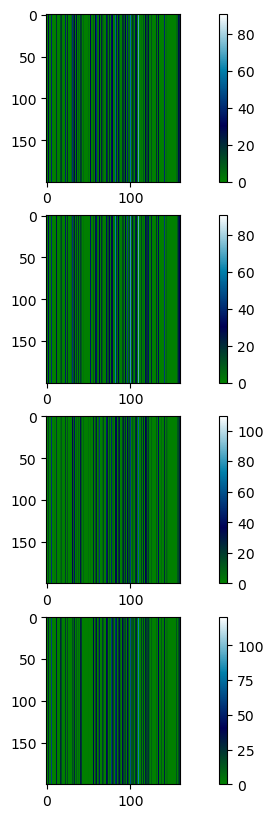

In [236]:
fig = plt.figure(figsize = (10, 10))
 
ax1 = fig.add_subplot(4,1,1)
im = plt.imshow(img1_graph, interpolation = "nearest", cmap = plt.cm.ocean)
plt.colorbar()
 
ax2 = fig.add_subplot(4,1,2)
im = plt.imshow(img2_graph, interpolation = "nearest", cmap = plt.cm.ocean)
plt.colorbar()

ax3 = fig.add_subplot(4,1,3)
im = plt.imshow(img3_graph, interpolation = "nearest", cmap = plt.cm.ocean)
plt.colorbar()

ax4 = fig.add_subplot(4,1,4)
im = plt.imshow(img4_graph, interpolation = "nearest", cmap = plt.cm.ocean)
plt.colorbar()
 
plt.show()